### Import libraries and load dataset

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, RocCurveDisplay
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from category_encoders import TargetEncoder

df = pd.read_csv("customer_booking.csv", encoding='ISO-8859-1')

### EDA

In [63]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [65]:
df.shape

(50000, 14)

In [66]:
df['num_passengers'].value_counts()

num_passengers
1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: count, dtype: int64

In [67]:
df['sales_channel'].value_counts()

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

In [68]:
df['trip_type'].value_counts()

trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

In [69]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [70]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [71]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

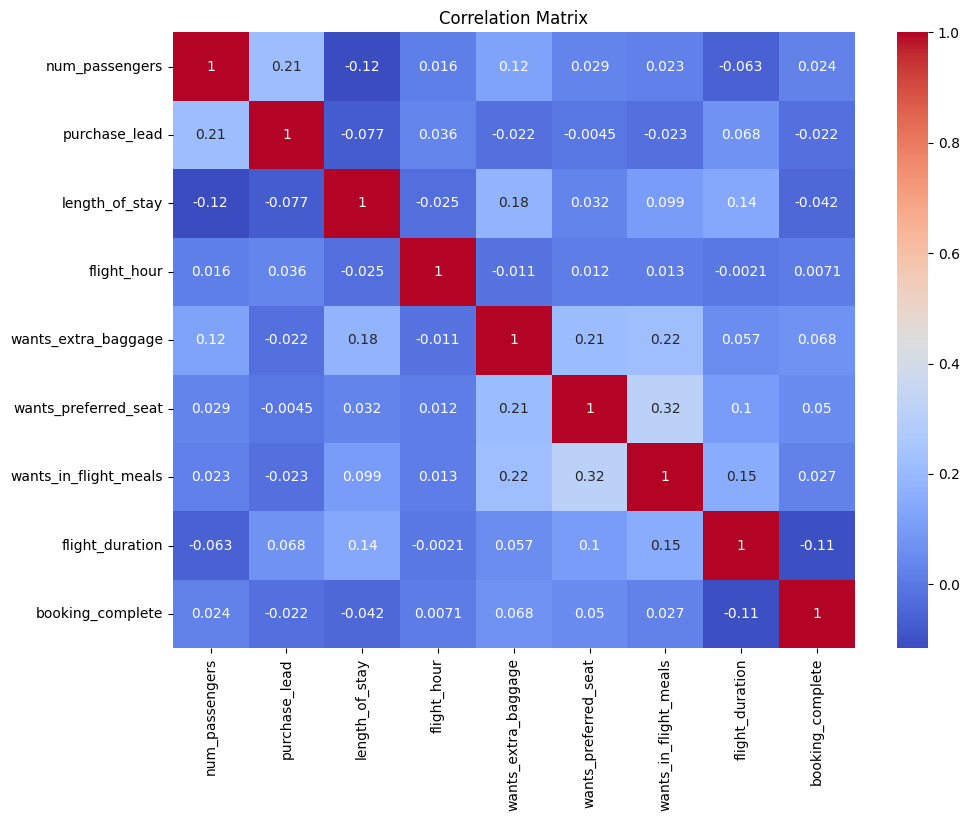

In [72]:
plt.figure(figsize=(11, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

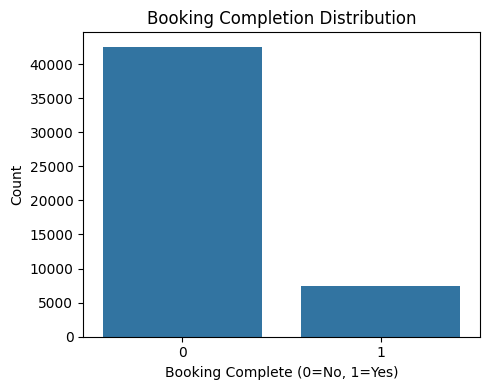

In [73]:
plt.figure(figsize=(5, 4))
sns.countplot(x='booking_complete', data=df)
plt.title("Booking Completion Distribution")
plt.xlabel("Booking Complete (0=No, 1=Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We can see that the dataset is imbalanced.

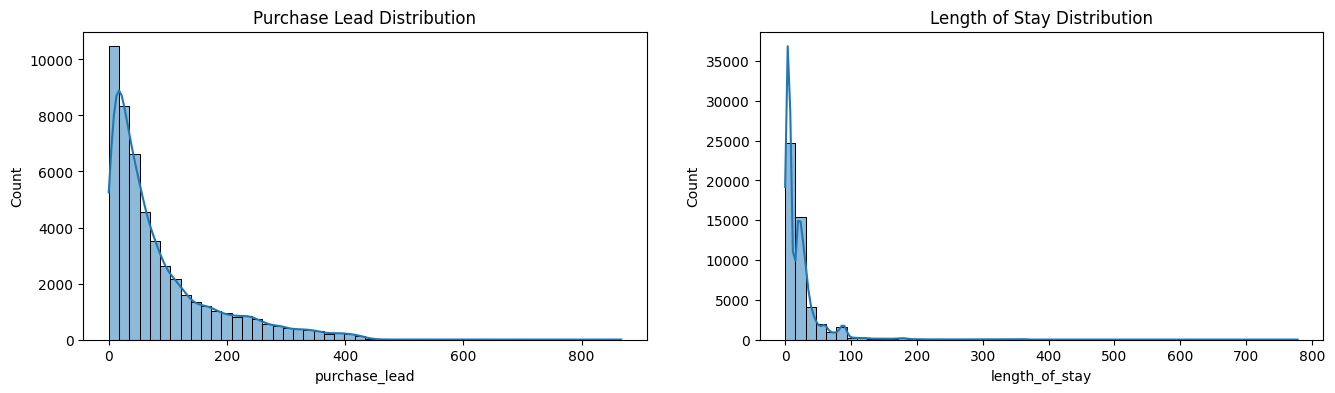

In [74]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['purchase_lead'], bins=50, kde=True)
plt.title("Purchase Lead Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['length_of_stay'], bins=50, kde=True)
plt.title("Length of Stay Distribution")

plt.show()

### Data Preprocessing & Feature Engineering

Check for skewness of the features

In [75]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)

length_of_stay           5.274743
num_passengers           2.690908
booking_complete         1.965292
purchase_lead            1.653035
wants_preferred_seat     0.888762
flight_hour              0.396623
wants_in_flight_meals    0.294593
flight_duration         -0.360080
wants_extra_baggage     -0.717239
dtype: float64


Apply log1p transformation to skewed numerical features to reduce the skewness

In [76]:
df['purchase_lead'] = np.log1p(df['purchase_lead'])
df['length_of_stay'] = np.log1p(df['length_of_stay'])

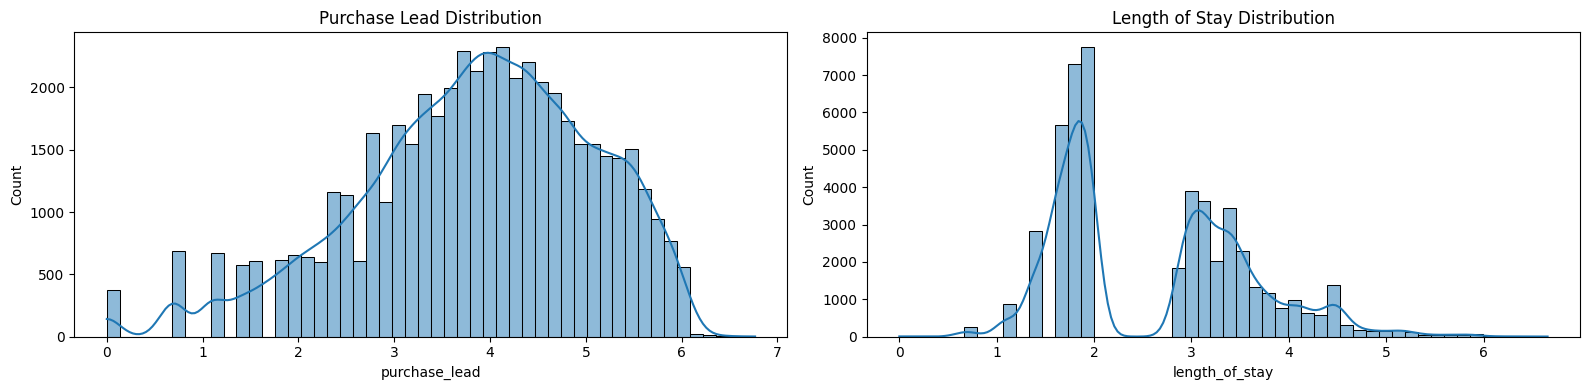

In [77]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['purchase_lead'], bins=50, kde=True)
plt.title("Purchase Lead Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['length_of_stay'], bins=50, kde=True)
plt.title("Length of Stay Distribution")


plt.tight_layout()
plt.show()

Map flight_day from strings to integers 

In [78]:
day_mapping = {'Mon': 1,'Tue': 2,'Wed': 3,'Thu': 4,'Fri': 5,'Sat': 6, 'Sun': 7}

df['flight_day'] = df['flight_day'].map(day_mapping)

Target Encoding replaces categorical values with the mean of the target variable. Generally used for high cardinality categorical features

In [ ]:
te = TargetEncoder(cols=['route', 'booking_origin'])
df[['route', 'booking_origin']] = te.fit_transform(df[['route', 'booking_origin']], df['booking_complete'])

Use pd.factorize() to encode categorical columns without expanding the dimensions

In [80]:
df['sales_channel'] = pd.factorize(df['sales_channel'])[0]
df['trip_type'] = pd.factorize(df['trip_type'])[0]

In [81]:
df.sample(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
30295,1,0,0,3.433987,1.609438,13,7,0.271429,0.231527,1,1,1,8.67,0
67,1,0,0,4.634729,4.709530,6,2,0.001001,0.101338,1,0,0,6.62,0
14630,1,0,0,4.143135,3.367296,10,7,0.007194,0.101338,1,0,0,8.58,0
1333,2,0,0,3.637586,2.890372,16,2,0.211567,0.344020,0,0,0,8.83,1
3195,1,0,0,4.532599,3.555348,9,4,0.106494,0.050358,1,1,1,5.62,1
21870,1,1,0,3.663562,3.178054,4,4,0.125000,0.050358,1,0,0,8.83,0
42879,2,1,0,5.837730,1.945910,5,1,0.404238,0.101338,0,0,0,6.33,0
33924,1,1,0,2.079442,1.609438,14,3,0.021739,0.050358,1,0,1,8.83,0
48760,4,0,0,5.384495,1.945910,5,4,0.096304,0.103150,1,1,1,8.83,0
2263,2,0,0,2.890372,3.091042,6,3,0.113598,0.204901,1,0,0,5.07,0


### Train-Test Split & SMOTENC

In [82]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

Define the pipeline using ImbPipeline that includes Random Forest Classifier and SMOTENC (SMOTE for categorical + numeric mix) by providing categorical feature indices to oversample minority class

In [91]:
cat_features = [X.columns.get_loc(col) for col in ['sales_channel', 'trip_type', 'flight_day','wants_extra_baggage', 'wants_in_flight_meals','wants_preferred_seat']]

pipeline = ImbPipeline([
    ('smote', SMOTENC(categorical_features=cat_features, random_state=7)),
    ('model', RandomForestClassifier(n_estimators=300,class_weight='balanced', random_state=7))
])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=7)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40000, 13), (40000,), (10000, 13), (10000,))

### Cross-Validation and Model Training

Use StratifiedKFold to maintain class balance during cross-validation.

In [93]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc',n_jobs=-1)
acc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1)

print("Cross-Validated ROC AUC:", round(roc_scores.mean(), 4))
print("Cross-Validated Accuracy:", round(acc_scores.mean(), 4))

Cross-Validated ROC AUC: 0.7914
Cross-Validated Accuracy: 0.8272


In [94]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[1, 2, 6, 9, 11, 10],
                         random_state=7)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=7))])

### Model Evaluation on Test Set

* Predict probabilities on the test set using predict_proba() and apply a custom threshold of 0.48 to convert probabilities to class predictions.
* The use of a custom threshold helps to balance precision and recall for the minority class.

In [104]:

y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.48).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))


Confusion Matrix:
 [[7644  860]
 [ 915  581]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      8504
           1       0.40      0.39      0.40      1496

    accuracy                           0.82     10000
   macro avg       0.65      0.64      0.65     10000
weighted avg       0.82      0.82      0.82     10000

Test Accuracy: 0.8225
Test ROC AUC: 0.7892


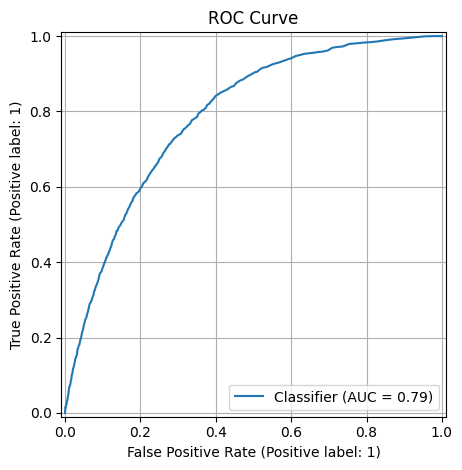

In [96]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Importance Visualization

C:\Users\Bhanu\AppData\Local\Temp\ipykernel_13832\1631334548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')


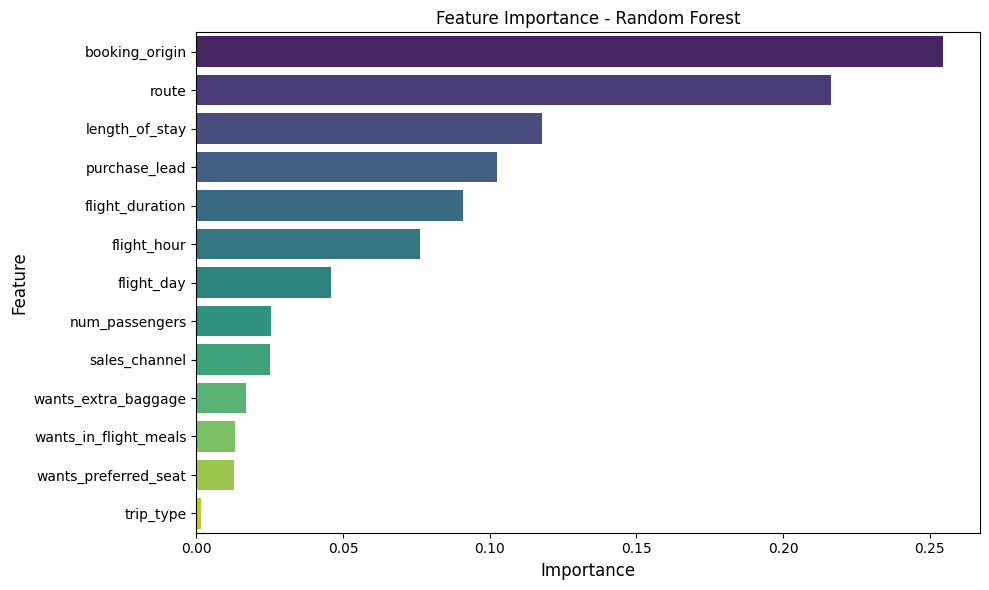

In [107]:
rf_model = pipeline.named_steps['model']
feat_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')
plt.title("Feature Importance - Random Forest", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()